In [1]:
import numpy as np
from math import erf
import matplotlib.pyplot as plt

In [2]:

#Geometric Brownian motion
class ProcessGBM:
    def __init__(self, mu, sigma):
        self._mu = mu
        self._sigma = sigma
    def Simulate(self, T=1, dt=0.001, S0=1.):
        n = round(T / dt)
        
        mu = self._mu
        sigma = self._sigma
        gaussian_increments = np.random.normal(size=n - 1)
        res = np.zeros(n)
        res[0] = S0
        S = S0
        sqrt_dt = dt ** 0.5
        for i in range(n - 1):
            S = S + S * mu * dt + sigma * \
                S * gaussian_increments[i] * sqrt_dt
            res[i + 1] = S
        return res
#Modele CEV 

class ProcessCEV:
    def __init__(self, mu, sigma, gamma):
        self._mu = mu
        self._sigma = sigma
        self._gamma = gamma
    def Simulate(self, T=1, dt=0.001, S0=1.):
        n = round(T / dt)
        
        mu = self._mu
        sigma = self._sigma
        gamma = self._gamma

        gaussian_increments = np.random.normal(size=n - 1)
        res = np.zeros(n)
        res[0] = S0
        S = S0
        sqrt_dt = dt ** 0.5
        for i in range(n - 1):
            S = S + S * mu * dt + sigma * \
                (S ** gamma) * gaussian_increments[i] * sqrt_dt
            res[i + 1] = S
        return res

In [3]:
##Calcul Parametres Modele CEV

class EstimatorCEV:

    def __init__(self, dt):
        self._dt = dt
        self._alpha0 = -5
    
    def Estimate(self, trajectory):
        sigma, gamma = self._evaluate_sigma_gamma(trajectory, self._alpha0)
        if sigma == None:
            return None, None, None
        else:
            mu = self._estimate_mu(trajectory)
            return (mu, sigma, gamma)

    def _log_increments(self, trajectory):
        return np.diff(trajectory) / trajectory[:-1]
    
    def _estimate_mu(self, trajectory):
        return np.mean(self._log_increments(trajectory)) / self._dt 

    def _log_increments_alpha(self, trajectory, alpha):
        mod_increments = self._log_increments(trajectory ** (1 + alpha))
        return mod_increments / (1 + alpha)

    def _evaluate_Vt(self, trajectory, alpha):
        lhs = self._log_increments_alpha(trajectory, alpha)
        rhs = self._log_increments(trajectory)
        center = 2 * (lhs - rhs) / (alpha * self._dt)
        return center

    def _evaluate_sigma_gamma(self, trajectory, alpha):
        if np.any(trajectory <= 0):
            return None, None
        
        Vts = self._evaluate_Vt(trajectory, alpha)
        if np.any(Vts <= 0):
            return None, None
        logVts = np.log(Vts)

        Sts = trajectory[:-1] 
        if np.any(Sts <= 0):
            return None, None
        logSts = np.log(Sts)

        ones = np.ones(Sts.shape[0])
        A = np.column_stack((ones, logSts))

        res = np.linalg.lstsq(A, logVts, rcond=-1.)[0]
        return (2 * np.exp(res[0] / 2), 0.5 * (res[1] + 2))



def estimer(true_mu, true_sigma, true_gamma):
    dt = 0.001
    T = 10
        
    sample_mu = []
    sample_sigma = []
    sample_gamma = []

    for i in range(100):
        mu_est, sigma_est, gamma_est = EstimatorCEV(dt=dt).Estimate(ProcessCEV(
            true_mu, true_sigma, true_gamma).Simulate(T, dt=dt))
            
        if mu_est != None:
            sample_mu = [mu_est] + sample_mu
            sample_sigma = [sigma_est] + sample_sigma
            sample_gamma = [gamma_est ] + sample_gamma
    
    print("mu : " + str(true_mu) + " \t| est : " + str(np.mean(sample_mu)) + "\t| std : " + str(np.std(sample_mu)))
    print("sigma : " + str(true_sigma) + " \t| est : " + str(np.mean(sample_sigma)) 
    + " \t| std : " + str(np.std(sample_sigma)))
    print("gamma : " + str(true_gamma) + " \t| est : " + str(np.mean(sample_gamma)) 
    + " \t| std : " + str(np.std(sample_gamma)))
    print(10*"-")


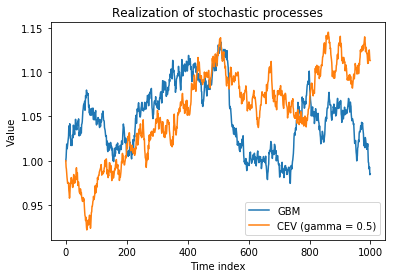

In [13]:
#paramètre :  r ∈ [0.03,0.1], µ ∈ [−0.05,0.2],
#σ ∈ [0.05,0.2], T entre 0.25 et 1 an, S 0 de l’ordre de quelques dizaines d’euros, K ∈ [0.8S 0 ,1.2S 0 ].
T = 1
dt = 0.001
plt.plot(ProcessGBM(0.05, 0.15).Simulate(T, dt), label="GBM")
plt.plot(ProcessCEV(0.05, 0.15, 0.5).Simulate(
    T, dt), label="CEV (gamma = 0.5)")
#plt.plot(ProcessCEV(0.05, 0.15, 1.5).Simulate(
  #  T, dt), label="CEV (gamma = 1.5)")

plt.xlabel('Time index')
plt.ylabel('Value')

plt.title("Realization of stochastic processes")

plt.legend()

plt.show()

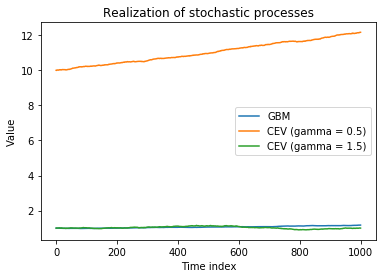

In [14]:
##
T = 1
dt = 0.001
plt.plot(ProcessGBM(0.2, 0.05).Simulate(T, dt), label="GBM")
plt.plot(ProcessCEV(0.2, 0.05, 0.5).Simulate(
    T, dt,10), label="CEV (gamma = 0.5)")
plt.plot(ProcessCEV(0.05, 0.15, 1.5).Simulate(
    T, dt), label="CEV (gamma = 1.5)")

plt.xlabel('Time index')
plt.ylabel('Value')

plt.title("Realization of stochastic processes")

plt.legend()

plt.show()

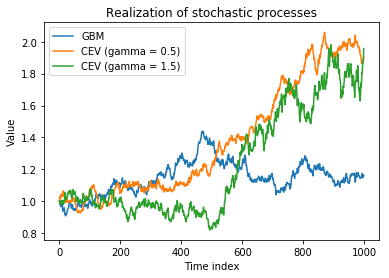

In [24]:
##
T = 10
dt = 0.01
plt.plot(ProcessGBM(0.05, 0.1).Simulate(T, dt), label="GBM")
plt.plot(ProcessCEV(0.05, 0.1, 0.5).Simulate(
    T, dt), label="CEV (gamma = 0.5)")
plt.plot(ProcessCEV(0.05, 0.15, 1.5).Simulate(
    T, dt), label="CEV (gamma = 1.5)")

plt.xlabel('Time index')
plt.ylabel('Value')

plt.title("Realization of stochastic processes")

plt.legend()

plt.show()

In [8]:
##Tests
estimer(-0.5,0.2,0.5)
estimer(0.02,0.1,0.5)
estimer(0.0,0.15,0.5)
estimer(0.2,0.13,0.5)
estimer(0.1,0.05,0.5)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


mu : -0.5 	| est : -0.06439705008070065	| std : 0.16504633609344502
sigma : 0.2 	| est : 0.21157552981674402 	| std : 0.004467240366476141
gamma : 0.5 	| est : 0.4996428263266647 	| std : 0.008062512773020485
----------
mu : 0.02 	| est : 0.01975075726542704	| std : 0.028848805215911773
sigma : 0.1 	| est : 0.1059016489724039 	| std : 0.0021183748939275927
gamma : 0.5 	| est : 0.4985947981385144 	| std : 0.11433463945867282
----------
mu : 0.0 	| est : 0.0018694189055859568	| std : 0.052481963907702066
sigma : 0.15 	| est : 0.15868730939218986 	| std : 0.003037311047925841
gamma : 0.5 	| est : 0.5003232161994167 	| std : 0.08267542248028528
----------
mu : 0.2 	| est : 0.19865831440381737	| std : 0.028088794383723113
sigma : 0.13 	| est : 0.13797222805258977 	| std : 0.0028990246251653982
gamma : 0.5 	| est : 0.5016465323832501 	| std : 0.01933264751910535
----------
mu : 0.1 	| est : 0.10121985646628912	| std : 0.012871082812482273
sigma : 0.05 	| est : 0.05325190268929859 	| std : 0.

In [12]:
##Calcul Prix Call

S0 = 15
K =0.9 * S0
r = 0.05
mu = 0.05
sigma = 0.1
def prix_call_statistique(T, K, r, S0, mu, sigma, gamma, pas):
    nb = 1000
   # nfin = 10000
    vect = np.zeros( nb)
       #On boucle sur 1000 simulations puis on prend la moyenne pour approximer
    # l'esperance
    for i in range(nb):
        ST =ProcessCEV(mu, sigma, gamma).Simulate(T, pas,S0)
        vect[i] = max(ST[round(T / pas)-1] - K,0)
        #print(vect[i])
    res = np.exp(-r * T) * np.mean(vect)
    return(res)
##
def prix_call_statistique2(T, K, r, S0, mu, sigma, betta, pas):
    nb = 1000
   # nfin = 10000
    vect = np.zeros( nb)
    for i in range(nb):
        oo = 3
        S = S0
        for j in range(round(T / pas)):
            if(oo >= 0):
                S += S * mu *pas + np.exp(.5 * betta * np.log(S)) * np.sqrt(pas)*sigma*np.random.normal(1,1)
            if (S <= 0) :
                oo = -2
        vect[i] = max(S - K,0)
        if (oo < 0) :
            vect[i] = 0
        #if vect[i] > 200 :
          #  vect[i] = 0
    res = np.exp(-r * T) * sum(vect)/nb
    return(res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


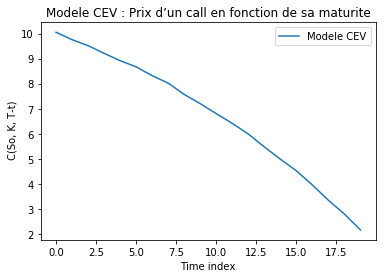

In [13]:
listet =[i for i in range(20)]
T =20
res = []
for t in listet:
    print(t)
    res.append(prix_call_statistique(T-t, K, r, S0, mu, sigma, 0.5, 0.01))
    
plt.figure()
plt.plot(listet,res, label="Modele CEV")

plt.xlabel('Time index')
plt.ylabel(' C(So, K, T-t)')

plt.title("Modele CEV : Prix d’un call en fonction de sa maturite")

plt.legend()
plt.show()

In [ ]:
##
res_blackscholes = []
T=20
for t in listet:
    print(t)
    res_blackscholes.append(prix_call_statistique(T-t, K, r, S0, mu, sigma, 1, 0.01))
##
listet2 =np.linspace(1,20,20)
res2 = []
for t in listet:
    res2.append(prix_call_statistique2(20, K, r, S0, mu, sigma, 1, 0.01))
    
##
S =ProcessCEV(mu, sigma,1).Simulate(20,0.01,S0)
##
print(S[-1])
##
print( np.exp(-r * 20))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
plt.figure()
plt.plot(listet,res_blackscholes, label="GBM")
plt.plot(listet,res, label="Modele CEV")

plt.xlabel('Time index')
plt.ylabel(' C(So, K, T-t)')

plt.title("Modele CEV : Prix d’un call en fonction de sa maturite")

plt.legend()

plt.show()

In [ ]:
print(S0-K)
##
for i in range(1000):
    ST =ProcessCEV(0.05, 0.1,0.5).Simulate(20, 0.1,S0)
    print(np.exp(-r * T)*max(ST[round(20 / 0.1)-1] - K,0))
##
l = [1,2,3,4,5,6]
l = np.flip(l,0)
print(l)

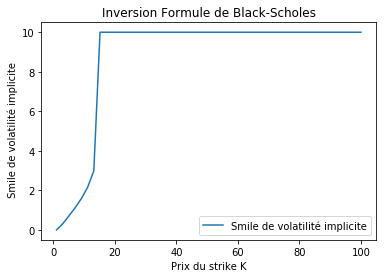

In [15]:
##
def prix(T, K, r, So, sigma):
    d1 = (np.log(So/K)+r*T)/(sigma*np.sqrt(T)) + 1/2*sigma*np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    res = So * phi(d1) - K *np. exp(-r * T) * phi(d2)
    return(res)
    
def  phi(x):
    res = 0
    if x >= 0 :
        res = 1/2 + 1/2 * erf(x/np.sqrt(2))
    else:
        res = 1/2 - 1/2 * erf((-x)/np.sqrt(2))
    return(res)

##Inversion sigma
#// sigma en fonction du prix
def inverser_bs(T, K, r, S0,p):
    a = 0
    b = 10
    while ((b - a) > .001):
        sigma = (a+b) / 2
        p_trouv = prix(T, K, r, S0, sigma)
        if (p_trouv < p):
            a = sigma;
        else:
            b = sigma
    res = sigma
    return(res)

##
S0 = 15
K =0.9*S0
r = 0.05
mu = 0.1
T = 1
listep = np.linspace(1,100,50)
sigma =np.zeros(len(listep))
for i in range(len(listep)):
    sigma[i] = inverser_bs(T, K, r, S0,listep[i])

##
plt.figure()
#plt.plot(listet,res_blackscholes, label="GBM")
plt.plot(listep,sigma, label="Smile de volatilité implicite")

plt.xlabel('Prix du strike K')
plt.ylabel(' Smile de volatilité implicite')

plt.title("Inversion Formule de Black-Scholes")

plt.legend()

plt.show()

In [25]:
##
def volatilite_implicite_blackScholes(C,T,r,S0):
    x = 0
    y = 10
    N = 1000
    for i in range(1,N):
        z = (x+y)/2
        if C > prix (T, C, r, S0, z):
           x=z
        else :
            y=z
    z =(x+y)/2
    return(z)

##
def sigma_implicite(gamma, K,T,r,S0,sigma):
    F0 = np.exp(-r*T)*S0
    Fm= (K + F0)
    return(sigma *(1+((1-gamma)*(2+gamma)*(F0-K)*(F0-K))/(Fm*Fm*24)+((1-gamma)*(1-gamma)*sigma*sigma*T)/(24*Fm**(2-2*gamma)))/(Fm**(1-gamma))) 
##
S0 = 15
K =0.9*S0
r = 0.05
T = 1
sigma = 0.1
listep = np.linspace(0,1000,1000)

l_sigma =np.zeros(len(listep))

for i in range(len(listep)):
    l_sigma[i] =sigma_implicite(0.5, i, T,r, S0,sigma)
##


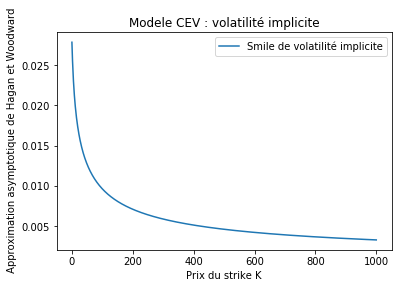

In [26]:
plt.figure()
plt.plot(listep,l_sigma, label="Smile de volatilité implicite")

plt.xlabel('Prix du strike K')
plt.ylabel(' Approximation asymptotique de Hagan et Woodward')

plt.title("Modele CEV : volatilité implicite")

plt.legend()

plt.show()

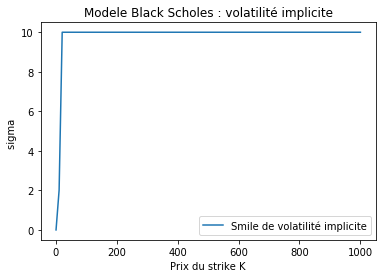

In [27]:
listep = np.linspace(1,1000,100)
sigma_black_scholes = np.zeros(len(listep))

for i in range(len(listep)):
    sigma_black_scholes[i] =volatilite_implicite_blackScholes( listep[i], T,r, S0)

##
plt.figure()
plt.plot(listep,sigma_black_scholes, label="Smile de volatilité implicite")

plt.xlabel('Prix du strike K')
plt.ylabel('sigma ')

plt.title("Modele Black Scholes : volatilité implicite")

plt.legend()

plt.show()